# Test model output

The following notebook contains tests of the output generated by model.
The tests check the legality of predicted moves and the correctness of predicted game result.

The tests are performed for model trained on tokenization with info about x and y coordinates and player (88 tokens)

In [1]:
import math
import os
import pickle
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from model import GPTConfig, GPT
from c4engine import C4Engine

In [2]:
OUT_DIR = 'out-connect-four-full'
DEVICE = 'cuda'

In [3]:
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16'
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = torch.amp.autocast(device_type=DEVICE, dtype=ptdtype)

Load model

In [4]:
# init from a model saved in a specific directory
ckpt_path = os.path.join(OUT_DIR, 'ckpt.pt')
checkpoint = torch.load(ckpt_path, map_location=DEVICE)
gptconf = GPTConfig(**checkpoint['model_args'])
model = GPT(gptconf)
state_dict = checkpoint['model']
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
model.load_state_dict(state_dict)
model.eval()
model.to(DEVICE)
# model = torch.compile(model)

number of parameters: 10.66M


GPT(
  (transformer): ModuleDict(
    (wte): Embedding(88, 384)
    (wpe): Embedding(44, 384)
    (drop): Dropout(p=0.2, inplace=False)
    (h): ModuleList(
      (0-5): 6 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=384, out_features=1152, bias=False)
          (c_proj): Linear(in_features=384, out_features=384, bias=False)
          (attn_dropout): Dropout(p=0.2, inplace=False)
          (resid_dropout): Dropout(p=0.2, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=384, out_features=1536, bias=False)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=1536, out_features=384, bias=False)
          (dropout): Dropout(p=0.2, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): Linear(in_features=384, out_features=88, bias=False)
)

Load dataset

In [5]:
# read metadata
data_dir = os.path.join('data', checkpoint['config']['dataset'])
meta_path = os.path.join(data_dir, 'meta.pkl')
with open(meta_path, 'rb') as f:
    meta = pickle.load(f)

# get encode/decode - tokenizer
stoi, itos, stom, separator = meta['stoi'], meta['itos'], meta['stom'], meta['separator']
split = lambda s: list(s) if separator == '' else s.split(separator)
encode = lambda s: [stoi[c] for c in split(s)]
decode = lambda l: separator.join(itos[i] for i in l)
str_to_moves = lambda s: ''.join(stom[c] for c in split(s))
ids_to_moves = lambda l: ''.join(stom[itos[i]] for i in l)

eos_token_ids = meta['eos_token_ids']

# read dataset
block_size = meta['block_size']
train_data = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r').reshape(-1, block_size+1)
val_data = np.memmap(os.path.join(data_dir, 'val.bin'), dtype=np.uint16, mode='r').reshape(-1, block_size+1)

## Legal move and game result prediction

In [6]:
def test_legal_move_and_game_result_prediction(data):
    move_seqs = set()
    correct_legal, total_legal = 0, 0
    correct_result, total_result = 0, 0

    for seq in data:
        engine = C4Engine()
        seq_moves = ids_to_moves(seq)
        for i in range(len(seq)):
            engine.make_move(seq_moves[i])

            if seq_moves[:i+1] in move_seqs:
                continue
            move_seqs.add(seq_moves[:i+1])

            # predict next token (move or game result)
            x = (torch.tensor(seq[:i+1], dtype=torch.long, device=DEVICE)[None, ...])
            y = model.generate(idx=x, max_new_tokens=1, top_k=1)
            predicted = ids_to_moves(y[0].tolist())[-1]

            # if game finished check predicted result
            if engine.result() is not None:
                if predicted == engine.result():
                    correct_result += 1
                total_result += 1
                break

            # check if predicted move is legal
            if engine.is_legal_move(predicted):
                correct_legal += 1
            total_legal += 1

    return correct_legal, total_legal, correct_result, total_result

In [7]:
correct_legal_val, total_legal_val, correct_result_val, total_result_val = test_legal_move_and_game_result_prediction(val_data)

In [8]:
print(f"Legal moves predicted (validation data): {correct_legal_val}/{total_legal_val} ({100.0*correct_legal_val/total_legal_val:.2f}%)")
print(f"Game result predicted (validation data): {correct_result_val}/{total_result_val} ({100.0*correct_result_val/total_result_val:.2f}%)")

Legal moves predicted (validation data): 59454/59665 (99.65%)
Game result predicted (validation data): 1800/2000 (90.00%)


In [9]:
correct_legal_train, total_legal_train, correct_result_train, total_result_train = test_legal_move_and_game_result_prediction(train_data)

In [10]:
print(f"Legal moves predicted (training data): {correct_legal_train}/{total_legal_train} ({100.0*correct_legal_train/total_legal_train:.2f}%)")
print(f"Game result predicted (training data): {correct_result_train}/{total_result_train} ({100.0*correct_result_train/total_result_train:.2f}%)")

Legal moves predicted (training data): 497649/498639 (99.80%)
Game result predicted (training data): 17053/18000 (94.74%)


## Probing

### Get output from hidden layers of the model

In [6]:
activations = {}
k_cache = {}
v_cache = {}

def get_hook(name):
    def hook(block, input, output):
        # get activations - i-th layer output (for last token only)
        activations[name] = output[:, -1, :].detach().cpu()

        # get Q,K,V values for i-th layer
        attn = block.attn
        k_cache[name] = attn.last_k
        v_cache[name] = attn.last_v

    return hook

# Register hooks on each block
for i, block in enumerate(model.transformer.h):
    block.register_forward_hook(get_hook(f'block_{i}'))

### Prepare dataset

In [7]:
field_to_int = {C4Engine.EMPTY: 0, C4Engine.PLAYERS[0]: 1, C4Engine.PLAYERS[1]: 2}
rng = np.random.default_rng(seed=9128)

def get_probe_dataset(data):
    move_seqs = set()
    X = {f'block_{i}': [] for i, _ in enumerate(model.transformer.h)}
    K = {f'block_{i}': [] for i, _ in enumerate(model.transformer.h)}
    V = {f'block_{i}': [] for i, _ in enumerate(model.transformer.h)}
    KV_mask = {f'block_{i}': [] for i, _ in enumerate(model.transformer.h)}
    Y_cell = []
    Y_col = []
    Y_row = []

    for seq in data:
        i = rng.integers(1, len(seq))
        seq_moves = ids_to_moves(seq[:i])
        # seq_moves = ids_to_moves(seq)
        # engine = C4Engine()
        # for i in range(len(seq)):
        # engine.make_move(seq_moves[i])
        engine = C4Engine(seq_moves)

        # if seq_moves[:i+1] in move_seqs:
        #     continue
        # move_seqs.add(seq_moves[:i+1])
        if seq_moves in move_seqs:
            continue
        move_seqs.add(seq_moves)

        board = engine.board()

        inp = (torch.tensor(seq[:i], dtype=torch.long, device=DEVICE)[None, ...])
        # inp = (torch.tensor(seq[:i+1], dtype=torch.long, device=DEVICE)[None, ...])
        _, _ = model(inp)
        for block in X.keys():
            X[block].append(activations[block].reshape(-1).cpu())
        for block in K.keys():
            K[block].append(k_cache[block])
        for block in V.keys():
            V[block].append(v_cache[block])
        Y_cell.append(torch.tensor([field_to_int[f] for row in board for f in row]))
        Y_col.append(torch.tensor([sum(1 for i in range(6) if board[i][j] in C4Engine.PLAYERS) for j in range(7)]))
        Y_row.append(torch.tensor([sum(1 for c in row if c in C4Engine.PLAYERS) for row in board]))

        # if engine.result() is not None:
        #     break

    N = len(Y_cell)

    for block in K.keys():
        Ks = K[block]
        Vs = V[block]

        T_max = max(k.shape[-2] for k in Ks)
        h = Ks[0].shape[1]
        d = Ks[0].shape[-1]

        K_pad = torch.zeros(N, T_max, d*h)
        V_pad = torch.zeros(N, T_max, d*h)
        mask  = torch.zeros(N, T_max, dtype=torch.bool)

        for i,(k,v) in enumerate(zip(Ks,Vs)):
            T = k.shape[-2]
            K_pad[i, :T, :] = k.squeeze(0).transpose(0,1).reshape(T, -1)
            V_pad[i, :T, :] = v.squeeze(0).transpose(0,1).reshape(T, -1)
            mask[i, :T] = 1

        K[block] = K_pad
        V[block] = V_pad
        KV_mask[block] = mask

    X = {block : torch.stack(X[block]) for block in X.keys()}
    Y_cell = torch.stack(Y_cell)
    Y_col = torch.stack(Y_col)
    Y_row = torch.stack(Y_row)

    return X, K, V, KV_mask, Y_cell, Y_col, Y_row

In [8]:
train_X, train_K, train_V, train_KV_mask, train_Y_cell, train_Y_col, train_Y_row = get_probe_dataset(train_data)

In [9]:
train_X['block_0'].shape, train_Y_cell.shape, train_Y_col.shape, train_Y_row.shape

(torch.Size([16304, 384]),
 torch.Size([16304, 42]),
 torch.Size([16304, 7]),
 torch.Size([16304, 6]))

In [10]:
train_K['block_0'].shape, train_V['block_0'].shape, train_KV_mask['block_0'].shape

(torch.Size([16304, 44, 384]),
 torch.Size([16304, 44, 384]),
 torch.Size([16304, 44]))

In [11]:
val_X, val_K, val_V, val_KV_mask, val_Y_cell, val_Y_col, val_Y_row = get_probe_dataset(val_data)

In [12]:
val_X['block_0'].shape, val_Y_cell.shape, val_Y_col.shape, val_Y_row.shape

(torch.Size([1892, 384]),
 torch.Size([1892, 42]),
 torch.Size([1892, 7]),
 torch.Size([1892, 6]))

In [13]:
val_K['block_0'].shape, val_V['block_0'].shape, val_KV_mask['block_0'].shape

(torch.Size([1892, 44, 384]),
 torch.Size([1892, 44, 384]),
 torch.Size([1892, 44]))

### Train linear probes

In [12]:
class LinearBoardProbe(nn.Module):
    def __init__(self, dim_x, dim_y, num_cls):
        super().__init__()
        # 42 cells × 3 classes
        self._dim_x = dim_x
        self._dim_y = dim_y
        self._num_cls = num_cls
        self.linear = nn.Linear(dim_x, dim_y * num_cls, device=DEVICE)

    def forward(self, x):
        # x: (B,384)
        out = self.linear(x)
        return out.view(-1, self._dim_y, self._num_cls)

In [13]:
def get_data_loader(X, Y, batch_size=1024):
    dataset = torch.utils.data.TensorDataset(X, Y)
    return torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True)

In [14]:
def train_probe(train_X, train_Y, val_X, val_Y, num_cls):
    results = {}
    for block in train_X.keys():
        print(block)

        probe = LinearBoardProbe(dim_x=train_X[block].shape[-1], dim_y=train_Y.shape[-1], num_cls=num_cls).to(DEVICE)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(
            probe.parameters(),
            lr=3e-4,
            weight_decay=1e-4
        )

        epochs = 1024
        batch_size = 1024

        train_loader = get_data_loader(train_X[block], train_Y, batch_size)
        val_loader = get_data_loader(val_X[block], val_Y, batch_size)

        for epoch in range(epochs):
            total_loss = 0
            for x, y in train_loader:
                x = x.to(DEVICE)
                y = y.to(DEVICE)

                preds = probe(x)

                loss = criterion(
                    preds.view(-1, probe._num_cls),
                    y.view(-1)
                )

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

            if epoch % 200 == 0:
                print(f'Epoch {epoch:3d}: {total_loss/len(train_loader):.4f}')

        print(f'Epoch {epoch:3d}: {total_loss/len(train_loader):.4f}')
        results[block] = (probe, train_loader, val_loader)

    return results

Predict value of each cell

In [15]:
cell_probe_results = train_probe(train_X, train_Y_cell, val_X, val_Y_cell, num_cls=3)

block_0
Epoch   0: 1.1057
Epoch 200: 0.4271
Epoch 400: 0.4031
Epoch 600: 0.3939
Epoch 800: 0.3893
Epoch 1000: 0.3869
Epoch 1023: 0.3866
block_1
Epoch   0: 1.1353
Epoch 200: 0.2786
Epoch 400: 0.2577
Epoch 600: 0.2506
Epoch 800: 0.2474
Epoch 1000: 0.2455
Epoch 1023: 0.2454
block_2
Epoch   0: 1.1846
Epoch 200: 0.2189
Epoch 400: 0.2022
Epoch 600: 0.1971
Epoch 800: 0.1948
Epoch 1000: 0.1936
Epoch 1023: 0.1934
block_3
Epoch   0: 1.2172
Epoch 200: 0.2025
Epoch 400: 0.1882
Epoch 600: 0.1838
Epoch 800: 0.1817
Epoch 1000: 0.1808
Epoch 1023: 0.1807
block_4
Epoch   0: 1.3035
Epoch 200: 0.2015
Epoch 400: 0.1874
Epoch 600: 0.1831
Epoch 800: 0.1814
Epoch 1000: 0.1805
Epoch 1023: 0.1804
block_5
Epoch   0: 1.3568
Epoch 200: 0.2103
Epoch 400: 0.1945
Epoch 600: 0.1898
Epoch 800: 0.1880
Epoch 1000: 0.1870
Epoch 1023: 0.1870


Predict number of pieces in each column

In [16]:
col_probe_results = train_probe(train_X, train_Y_col, val_X, val_Y_col, num_cls=7)

block_0
Epoch   0: 1.9684
Epoch 200: 0.6282
Epoch 400: 0.5635
Epoch 600: 0.5338
Epoch 800: 0.5158
Epoch 1000: 0.5033
Epoch 1023: 0.5023
block_1
Epoch   0: 1.9230
Epoch 200: 0.2747
Epoch 400: 0.2210
Epoch 600: 0.1988
Epoch 800: 0.1867
Epoch 1000: 0.1791
Epoch 1023: 0.1785
block_2
Epoch   0: 2.0003
Epoch 200: 0.0981
Epoch 400: 0.0675
Epoch 600: 0.0567
Epoch 800: 0.0519
Epoch 1000: 0.0492
Epoch 1023: 0.0491
block_3
Epoch   0: 2.1361
Epoch 200: 0.0486
Epoch 400: 0.0295
Epoch 600: 0.0239
Epoch 800: 0.0219
Epoch 1000: 0.0209
Epoch 1023: 0.0208
block_4
Epoch   0: 2.2602
Epoch 200: 0.0357
Epoch 400: 0.0212
Epoch 600: 0.0172
Epoch 800: 0.0156
Epoch 1000: 0.0149
Epoch 1023: 0.0149
block_5
Epoch   0: 2.3711
Epoch 200: 0.0389
Epoch 400: 0.0239
Epoch 600: 0.0189
Epoch 800: 0.0171
Epoch 1000: 0.0160
Epoch 1023: 0.0160


Predict number of pieces in each row

In [17]:
row_probe_results = train_probe(train_X, train_Y_row, val_X, val_Y_row, num_cls=8)

block_0
Epoch   0: 2.0321
Epoch 200: 0.7719
Epoch 400: 0.7151
Epoch 600: 0.6896
Epoch 800: 0.6743
Epoch 1000: 0.6639
Epoch 1023: 0.6630
block_1
Epoch   0: 2.1242
Epoch 200: 0.6547
Epoch 400: 0.5873
Epoch 600: 0.5572
Epoch 800: 0.5393
Epoch 1000: 0.5269
Epoch 1023: 0.5260
block_2
Epoch   0: 2.1859
Epoch 200: 0.5420
Epoch 400: 0.4642
Epoch 600: 0.4302
Epoch 800: 0.4112
Epoch 1000: 0.3986
Epoch 1023: 0.3977
block_3
Epoch   0: 2.1618
Epoch 200: 0.4711
Epoch 400: 0.3921
Epoch 600: 0.3585
Epoch 800: 0.3402
Epoch 1000: 0.3284
Epoch 1023: 0.3271
block_4
Epoch   0: 2.3584
Epoch 200: 0.4694
Epoch 400: 0.3930
Epoch 600: 0.3606
Epoch 800: 0.3429
Epoch 1000: 0.3309
Epoch 1023: 0.3296
block_5
Epoch   0: 2.4777
Epoch 200: 0.5253
Epoch 400: 0.4546
Epoch 600: 0.4226
Epoch 800: 0.4041
Epoch 1000: 0.3920
Epoch 1023: 0.3909


### Test linear probes

In [18]:
def eval_probe_results(probe_results, dim):
    train_accuracies = {}
    val_accuracies = {}

    for block in probe_results.keys():
        probe, train_loader, val_loader = probe_results[block]

        def eval_loader(loader):
            correct = torch.zeros(dim, device=DEVICE)
            total = torch.zeros(dim, device=DEVICE)

            with torch.no_grad():
                for x, y in loader:
                    x = x.to(DEVICE)
                    y = y.to(DEVICE)

                    preds = probe(x)
                    pred_cls = preds.argmax(dim=-1)
                    matches = (pred_cls == y).float()

                    correct += matches.sum(dim=0)
                    total += torch.ones_like(matches).sum(dim=0)

            return correct / total

        train_accuracies[block] = eval_loader(train_loader)
        val_accuracies[block] = eval_loader(val_loader)

    return train_accuracies, val_accuracies

In [14]:
def plot_heatmaps(acc_dict, w, h, title, xlabel, ylabel, disable_yticks=False, disable_xticks=False, max_cols=3):
    keys = sorted(acc_dict.keys())
    n = len(keys)

    # Grid layout
    cols = min(n, max_cols)
    rows = math.ceil(n / cols)

    fig, axes = plt.subplots(
        rows,
        cols,
        figsize=(4 * cols, 4 * rows),
        squeeze=False
    )

    fig.suptitle(title, fontsize=16)

    for idx, key in enumerate(keys):
        r = idx // cols
        c = idx % cols
        ax = axes[r][c]
        board = acc_dict[key].view(h, w).cpu()
        im = ax.imshow(board, vmin=0.4, vmax=1)
        ax.set_title(key)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)

        if disable_yticks:
            ax.set_yticks([])
        if disable_xticks:
            ax.set_xticks([])

        # Cell values
        for i in range(h):
            for j in range(w):
                val = board[i, j].item()
                ax.text(
                    j, i,
                    f"{val:.2f}",
                    ha="center",
                    va="center",
                    fontsize=9
                )

    # Remove empty subplots
    for i in range(n, rows * cols):
        fig.delaxes(axes[i // cols][i % cols])

    # Shared colorbar
    plt.subplots_adjust(right=0.88)
    cbar_ax = fig.add_axes([0.90, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax, label="Accuracy")

    plt.show()

Per cell

In [20]:
train_acc_cell, val_acc_cell = eval_probe_results(cell_probe_results, dim=train_Y_cell.shape[-1])

In [21]:
train_acc_cell

{'block_0': tensor([0.8893, 0.9076, 0.8951, 0.9113, 0.9171, 0.9486, 0.9658, 0.8329, 0.8613,
         0.8636, 0.8554, 0.8892, 0.9236, 0.9526, 0.8170, 0.8242, 0.8266, 0.8970,
         0.8752, 0.8708, 0.9119, 0.7892, 0.8481, 0.8351, 0.8686, 0.8656, 0.8414,
         0.8689, 0.7572, 0.7743, 0.8223, 0.8548, 0.8076, 0.7864, 0.8046, 0.7355,
         0.7307, 0.7226, 0.7921, 0.7074, 0.7151, 0.7083], device='cuda:0'),
 'block_1': tensor([0.9115, 0.9200, 0.9246, 0.9333, 0.9376, 0.9636, 0.9744, 0.8669, 0.8909,
         0.9054, 0.9315, 0.9291, 0.9427, 0.9654, 0.8516, 0.8844, 0.9111, 0.9629,
         0.9384, 0.9159, 0.9433, 0.8247, 0.9078, 0.9434, 0.9507, 0.9503, 0.9133,
         0.8916, 0.8367, 0.8581, 0.9170, 0.9592, 0.9006, 0.8881, 0.9032, 0.8099,
         0.8168, 0.8058, 0.8948, 0.7952, 0.8087, 0.8447], device='cuda:0'),
 'block_2': tensor([0.9162, 0.9259, 0.9269, 0.9456, 0.9452, 0.9652, 0.9754, 0.8834, 0.9045,
         0.9143, 0.9498, 0.9403, 0.9474, 0.9671, 0.8630, 0.9071, 0.9291, 0.9709,
     

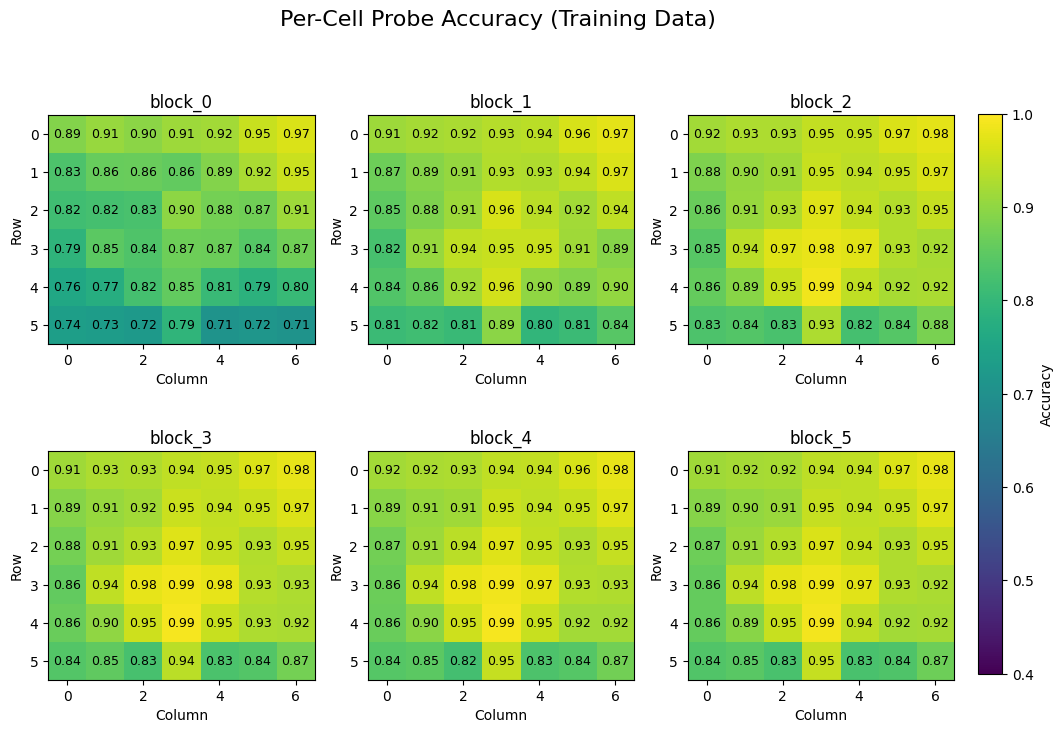

In [22]:
plot_heatmaps(train_acc_cell, w=7, h=6, title=f'Per-Cell Probe Accuracy (Training Data)', xlabel='Column', ylabel='Row')

In [23]:
val_acc_cell

{'block_0': tensor([0.8774, 0.9070, 0.8864, 0.9043, 0.9033, 0.9403, 0.9588, 0.8150, 0.8568,
         0.8647, 0.8451, 0.8800, 0.9117, 0.9440, 0.8081, 0.8177, 0.8293, 0.8953,
         0.8716, 0.8536, 0.8990, 0.7738, 0.8425, 0.8182, 0.8568, 0.8573, 0.8446,
         0.8631, 0.7426, 0.7822, 0.8182, 0.8399, 0.8013, 0.7743, 0.8002, 0.7104,
         0.6966, 0.7162, 0.7722, 0.7109, 0.6982, 0.7014], device='cuda:0'),
 'block_1': tensor([0.8953, 0.9138, 0.9202, 0.9265, 0.9244, 0.9498, 0.9651, 0.8399, 0.8911,
         0.9059, 0.9302, 0.9059, 0.9334, 0.9514, 0.8340, 0.8742, 0.9017, 0.9514,
         0.9323, 0.9075, 0.9350, 0.8092, 0.8980, 0.9281, 0.9382, 0.9424, 0.9027,
         0.8837, 0.8351, 0.8541, 0.8948, 0.9540, 0.9059, 0.8795, 0.8885, 0.7939,
         0.8018, 0.7960, 0.8906, 0.7859, 0.7923, 0.8177], device='cuda:0'),
 'block_2': tensor([0.8980, 0.9165, 0.9276, 0.9339, 0.9271, 0.9493, 0.9651, 0.8668, 0.8985,
         0.9064, 0.9466, 0.9149, 0.9355, 0.9577, 0.8589, 0.8953, 0.9123, 0.9604,
     

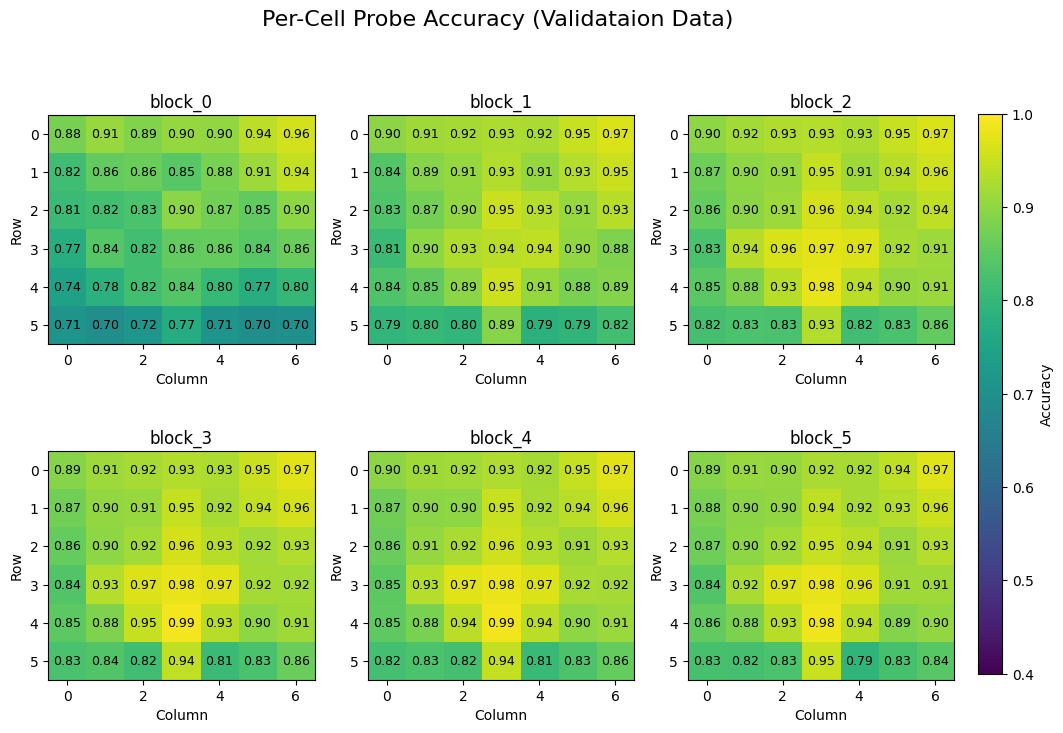

In [24]:
plot_heatmaps(val_acc_cell, w=7, h=6, title=f'Per-Cell Probe Accuracy (Validataion Data)', xlabel='Column', ylabel='Row')

Per column

In [25]:
train_acc_col, val_acc_col = eval_probe_results(col_probe_results, dim=train_Y_col.shape[-1])

In [26]:
train_acc_col

{'block_0': tensor([0.8216, 0.8299, 0.8321, 0.8443, 0.8084, 0.8132, 0.8048],
        device='cuda:0'),
 'block_1': tensor([0.9417, 0.9472, 0.9495, 0.9560, 0.9468, 0.9512, 0.9349],
        device='cuda:0'),
 'block_2': tensor([0.9883, 0.9916, 0.9895, 0.9928, 0.9938, 0.9916, 0.9887],
        device='cuda:0'),
 'block_3': tensor([0.9941, 0.9974, 0.9985, 0.9971, 0.9996, 0.9988, 0.9971],
        device='cuda:0'),
 'block_4': tensor([0.9963, 0.9977, 0.9977, 0.9981, 0.9994, 0.9990, 0.9980],
        device='cuda:0'),
 'block_5': tensor([0.9971, 0.9969, 0.9963, 0.9983, 0.9993, 0.9982, 0.9980],
        device='cuda:0')}

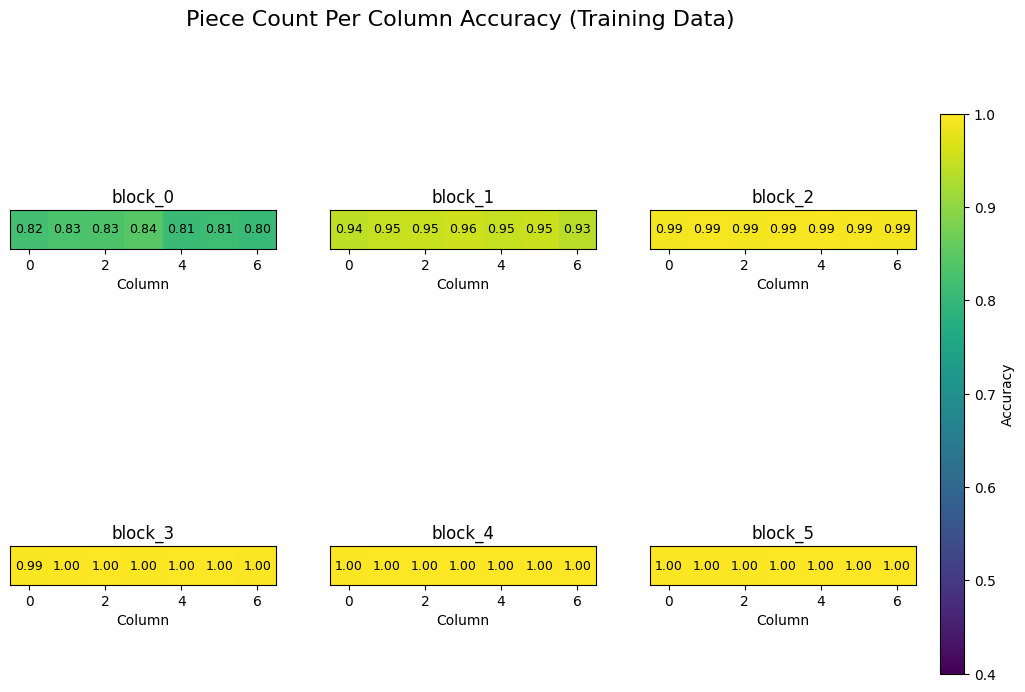

In [27]:
plot_heatmaps(train_acc_col, w=7, h=1, title=f'Piece Count Per Column Accuracy (Training Data)', xlabel='Column', ylabel='', disable_yticks=True)

In [28]:
val_acc_col

{'block_0': tensor([0.8007, 0.8034, 0.8044, 0.8182, 0.7986, 0.7923, 0.8007],
        device='cuda:0'),
 'block_1': tensor([0.9149, 0.9334, 0.9329, 0.9355, 0.9297, 0.9434, 0.9133],
        device='cuda:0'),
 'block_2': tensor([0.9741, 0.9810, 0.9746, 0.9762, 0.9752, 0.9799, 0.9757],
        device='cuda:0'),
 'block_3': tensor([0.9884, 0.9863, 0.9868, 0.9873, 0.9905, 0.9942, 0.9894],
        device='cuda:0'),
 'block_4': tensor([0.9942, 0.9905, 0.9873, 0.9921, 0.9915, 0.9963, 0.9910],
        device='cuda:0'),
 'block_5': tensor([0.9900, 0.9878, 0.9826, 0.9915, 0.9889, 0.9915, 0.9873],
        device='cuda:0')}

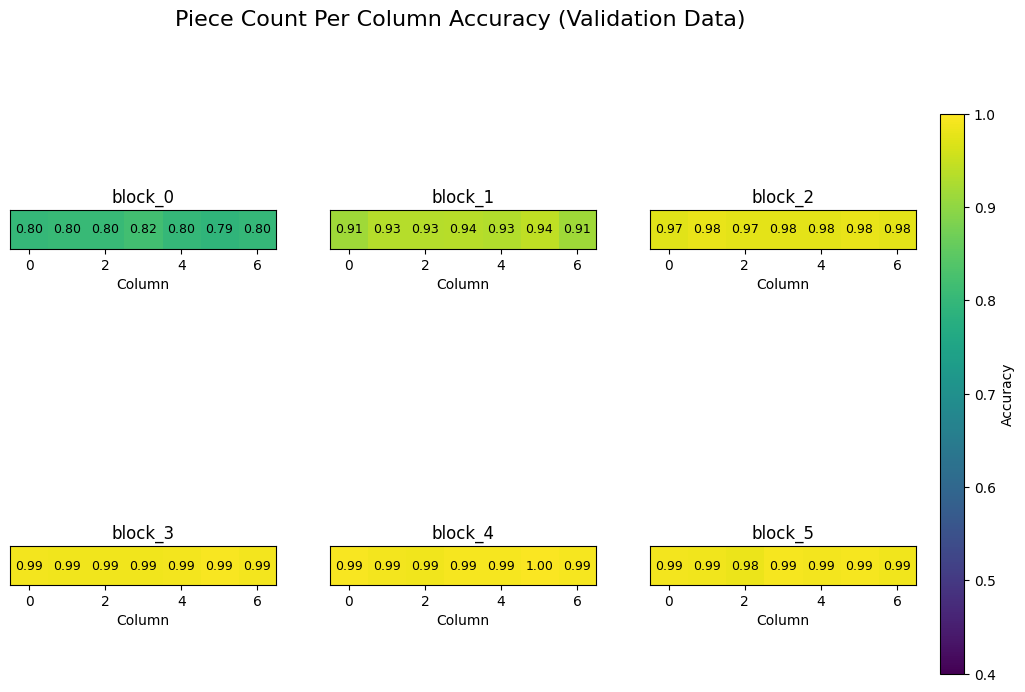

In [29]:
plot_heatmaps(val_acc_col, w=7, h=1, title=f'Piece Count Per Column Accuracy (Validation Data)', xlabel='Column', ylabel='', disable_yticks=True)

Per row

In [30]:
train_acc_row, val_acc_row = eval_probe_results(row_probe_results, dim=train_Y_row.shape[-1])

In [31]:
train_acc_row

{'block_0': tensor([0.8159, 0.7475, 0.7314, 0.7147, 0.6808, 0.6657], device='cuda:0'),
 'block_1': tensor([0.8836, 0.8015, 0.7877, 0.7606, 0.7572, 0.7531], device='cuda:0'),
 'block_2': tensor([0.9146, 0.8616, 0.8446, 0.8365, 0.8368, 0.8281], device='cuda:0'),
 'block_3': tensor([0.9185, 0.8846, 0.8651, 0.8746, 0.8847, 0.8775], device='cuda:0'),
 'block_4': tensor([0.9059, 0.8752, 0.8567, 0.8659, 0.8823, 0.9086], device='cuda:0'),
 'block_5': tensor([0.8781, 0.8369, 0.8224, 0.8327, 0.8574, 0.8960], device='cuda:0')}

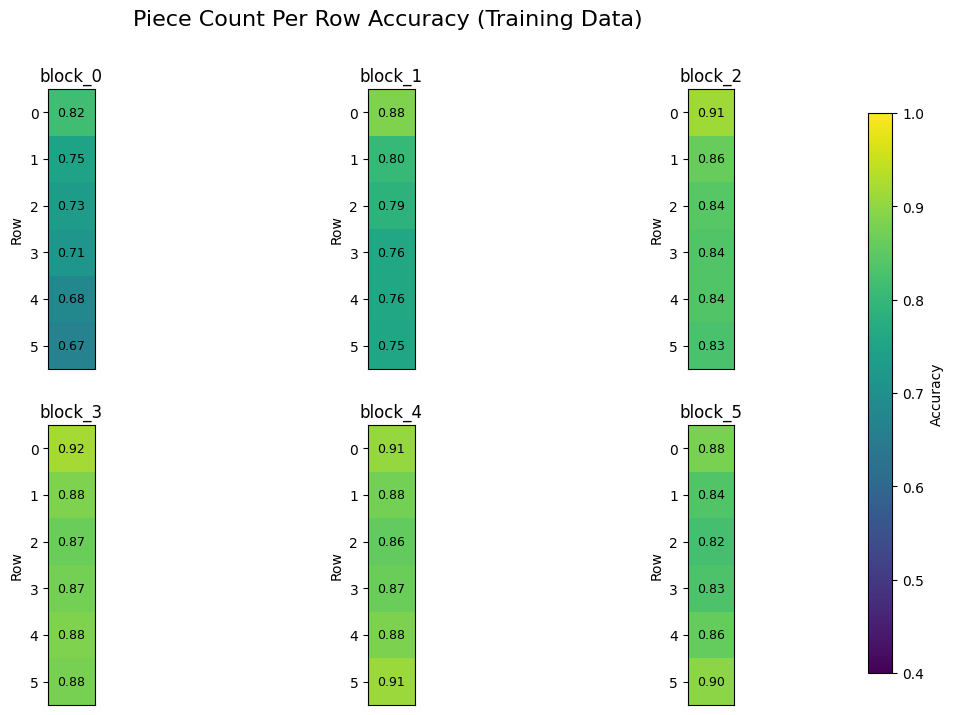

In [32]:
plot_heatmaps(train_acc_row, w=1, h=6, title=f'Piece Count Per Row Accuracy (Training Data)', xlabel='', ylabel='Row', disable_xticks=True)

In [33]:
val_acc_row

{'block_0': tensor([0.8013, 0.7347, 0.7172, 0.6808, 0.6533, 0.6686], device='cuda:0'),
 'block_1': tensor([0.8642, 0.7632, 0.7606, 0.7104, 0.7209, 0.7447], device='cuda:0'),
 'block_2': tensor([0.8922, 0.8219, 0.8013, 0.8007, 0.7992, 0.8071], device='cuda:0'),
 'block_3': tensor([0.8932, 0.8478, 0.8060, 0.8356, 0.8462, 0.8647], device='cuda:0'),
 'block_4': tensor([0.8758, 0.8245, 0.8018, 0.8309, 0.8430, 0.8885], device='cuda:0'),
 'block_5': tensor([0.8409, 0.7992, 0.7548, 0.7891, 0.8177, 0.8621], device='cuda:0')}

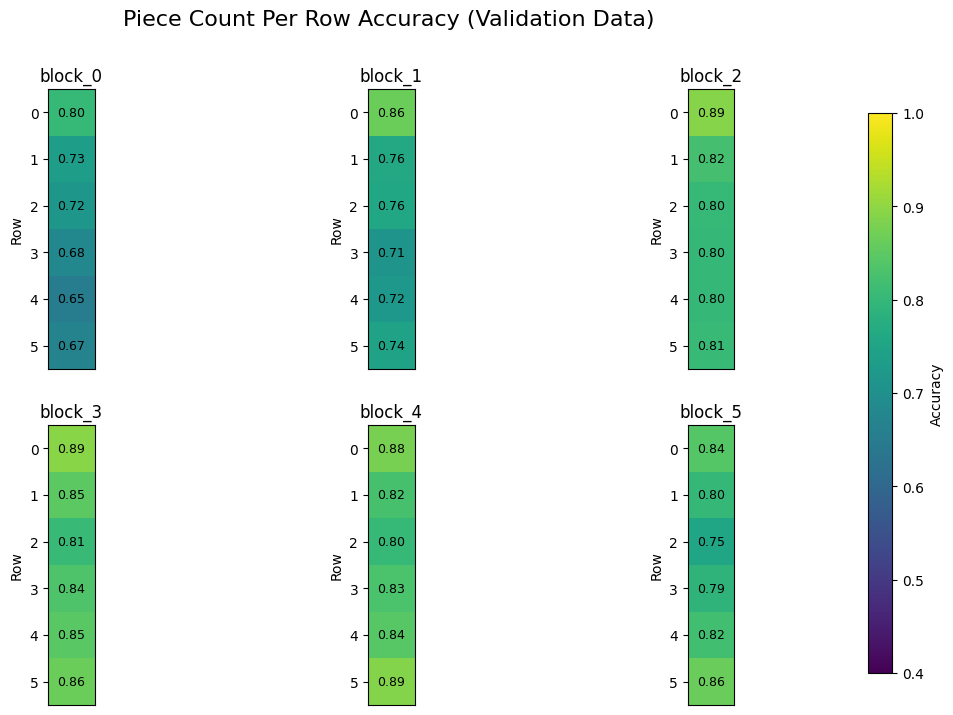

In [34]:
plot_heatmaps(val_acc_row, w=1, h=6, title=f'Piece Count Per Row Accuracy (Validation Data)', xlabel='', ylabel='Row', disable_xticks=True)

### Train Attention (QKV) Probes

For cell $y$:
$$ \alpha_y = \text{softmax}(Q_y K) $$
$$ z_y = \sum_{t} \alpha_{y,t} V_t $$
Final prediction:
$$ \text{MLP}(z_y) $$

In [15]:
class AttentionProbe(nn.Module):
    def __init__(self, dim_x, dim_y, num_cls):
        super().__init__()

        self._dim_x = dim_x
        self._dim_y = dim_y
        self._num_cls = num_cls

        self.q = nn.Parameter(torch.randn(dim_y, dim_x))
        self.mlp = nn.Sequential(
            nn.Linear(dim_x * dim_y, 128),
            nn.ReLU(),
            nn.Linear(128, dim_y * num_cls)
        )

    def forward(self, K, V, mask):
        scores = torch.einsum("yd,btd->byt", self.q, K)
        scores = scores.masked_fill(mask[:, None, :] == 0, -1e9)

        alpha = torch.softmax(scores, dim=-1)

        z = torch.einsum("byt,btd->byd", alpha, V)
        z = z.reshape(z.size(0), -1)

        out = self.mlp(z)

        return out.view(-1, self._dim_y, self._num_cls)

In [50]:
def train_attention_probe(train_K, train_V, train_mask, train_Y, num_cls):
    results = {}
    for block in train_K.keys():
        print(block)

        probe = AttentionProbe(
            dim_x=train_K[block].shape[-1],
            dim_y=train_Y.shape[-1],
            num_cls=num_cls
        ).to(DEVICE)

        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(
            probe.parameters(),
            lr=7e-4,
            weight_decay=1e-4
        )

        epochs = 150
        batch_size = 4096
        N = train_K[block].shape[0]

        for epoch in range(epochs):
            probe.train()

            perm = torch.randperm(N)
            total_loss = 0.0

            for i in range(0, N, batch_size):
                idx = perm[i:i+batch_size]

                K = train_K[block][idx].to(DEVICE)
                V = train_V[block][idx].to(DEVICE)
                mask = train_mask[block][idx].to(DEVICE)
                Y = train_Y[idx].to(DEVICE)

                logits = probe(K, V, mask)

                loss = criterion(
                    logits.view(-1, logits.size(-1)),
                    Y.view(-1)
                )

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                total_loss += loss.item() * K.size(0)

            avg_loss = total_loss / N
            if epoch % 50 == 0:
                print(f"Epoch {epoch} | train loss {avg_loss:.4f}")

        print(f"Epoch {epoch} | train loss {avg_loss:.4f}")
        results[block] = probe

    return results

Per cell

In [51]:
cell_attention_probe_results = train_attention_probe(train_K, train_V, train_KV_mask, train_Y_cell, num_cls=3)

block_0
Epoch 0 | train loss 0.9115
Epoch 50 | train loss 0.0261
Epoch 100 | train loss 0.0122
Epoch 149 | train loss 0.0078
block_1
Epoch 0 | train loss 0.9333
Epoch 50 | train loss 0.0320
Epoch 100 | train loss 0.0130
Epoch 149 | train loss 0.0082
block_2
Epoch 0 | train loss 0.9528
Epoch 50 | train loss 0.0258
Epoch 100 | train loss 0.0099
Epoch 149 | train loss 0.0066
block_3
Epoch 0 | train loss 0.9543
Epoch 50 | train loss 0.0288
Epoch 100 | train loss 0.0115
Epoch 149 | train loss 0.0074
block_4
Epoch 0 | train loss 0.9354
Epoch 50 | train loss 0.0234
Epoch 100 | train loss 0.0102
Epoch 149 | train loss 0.0073
block_5
Epoch 0 | train loss 0.9295
Epoch 50 | train loss 0.0259
Epoch 100 | train loss 0.0121
Epoch 149 | train loss 0.0090


Per column

In [52]:
col_attention_probe_results = train_attention_probe(train_K, train_V, train_KV_mask, train_Y_col, num_cls=7)

block_0
Epoch 0 | train loss 1.8378
Epoch 50 | train loss 0.5932
Epoch 100 | train loss 0.4089
Epoch 149 | train loss 0.2767
block_1
Epoch 0 | train loss 1.8324
Epoch 50 | train loss 0.2860
Epoch 100 | train loss 0.1422
Epoch 149 | train loss 0.0907
block_2
Epoch 0 | train loss 1.8343
Epoch 50 | train loss 0.2516
Epoch 100 | train loss 0.1176
Epoch 149 | train loss 0.0703
block_3
Epoch 0 | train loss 1.8152
Epoch 50 | train loss 0.2523
Epoch 100 | train loss 0.0975
Epoch 149 | train loss 0.0498
block_4
Epoch 0 | train loss 1.8193
Epoch 50 | train loss 0.1942
Epoch 100 | train loss 0.0893
Epoch 149 | train loss 0.0477
block_5
Epoch 0 | train loss 1.8569
Epoch 50 | train loss 0.2514
Epoch 100 | train loss 0.1087
Epoch 149 | train loss 0.0590


Per row

In [53]:
row_attention_probe_results = train_attention_probe(train_K, train_V, train_KV_mask, train_Y_row, num_cls=8)

block_0
Epoch 0 | train loss 1.9660
Epoch 50 | train loss 0.7410
Epoch 100 | train loss 0.5751
Epoch 149 | train loss 0.4932
block_1
Epoch 0 | train loss 1.9415
Epoch 50 | train loss 0.6156
Epoch 100 | train loss 0.4534
Epoch 149 | train loss 0.3631
block_2
Epoch 0 | train loss 1.9168
Epoch 50 | train loss 0.5918
Epoch 100 | train loss 0.4157
Epoch 149 | train loss 0.3222
block_3
Epoch 0 | train loss 1.9162
Epoch 50 | train loss 0.4775
Epoch 100 | train loss 0.3035
Epoch 149 | train loss 0.2158
block_4
Epoch 0 | train loss 1.9618
Epoch 50 | train loss 0.5753
Epoch 100 | train loss 0.3690
Epoch 149 | train loss 0.2525
block_5
Epoch 0 | train loss 1.9755
Epoch 50 | train loss 0.5838
Epoch 100 | train loss 0.3889
Epoch 149 | train loss 0.2894


### Test Attention Probes

In [54]:
def eval_attention_probe_results(probes, Ks, Vs, masks, Ys, dim):
    acc = {}
    batch_size = 2048

    for block in probes.keys():
        probe = probes[block]
        probe.eval()

        N = Ks[block].shape[0]

        correct = torch.zeros(dim, device=DEVICE)
        total = torch.zeros(dim, device=DEVICE)

        for i in range(0, N, batch_size):
            K = Ks[block][i:i+batch_size].to(DEVICE)
            V = Vs[block][i:i+batch_size].to(DEVICE)
            mask = masks[block][i:i+batch_size].to(DEVICE)
            Y = Ys[i:i+batch_size].to(DEVICE)

            logits = probe(K, V, mask)
            pred = logits.argmax(dim=-1)
            matches = (pred == Y).float()

            correct += matches.sum(dim=0)
            total += torch.ones_like(matches).sum(dim=0)

        acc[block] = correct / total

    return acc

Per cell

In [55]:
train_attention_acc_cell = eval_attention_probe_results(cell_attention_probe_results, train_K, train_V, train_KV_mask, train_Y_cell, train_Y_cell.shape[-1])
train_attention_acc_cell

{'block_0': tensor([0.9999, 1.0000, 1.0000, 0.9999, 0.9999, 0.9991, 0.9995, 0.9998, 1.0000,
         0.9998, 0.9996, 0.9999, 0.9994, 0.9992, 0.9999, 1.0000, 0.9998, 0.9999,
         0.9997, 0.9998, 1.0000, 1.0000, 1.0000, 0.9999, 1.0000, 0.9999, 0.9998,
         0.9993, 0.9999, 1.0000, 1.0000, 0.9998, 0.9995, 0.9996, 0.9999, 1.0000,
         0.9999, 0.9999, 0.9997, 0.9993, 1.0000, 0.9999], device='cuda:0'),
 'block_1': tensor([0.9999, 0.9999, 1.0000, 1.0000, 0.9997, 0.9997, 0.9998, 0.9998, 0.9999,
         0.9998, 1.0000, 0.9999, 1.0000, 0.9999, 0.9998, 0.9999, 0.9999, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9997,
         0.9962, 1.0000, 0.9999, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9999], device='cuda:0'),
 'block_2': tensor([0.9998, 0.9999, 0.9999, 1.0000, 1.0000, 0.9998, 0.9999, 1.0000, 1.0000,
         1.0000, 1.0000, 0.9999, 0.9999, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
     

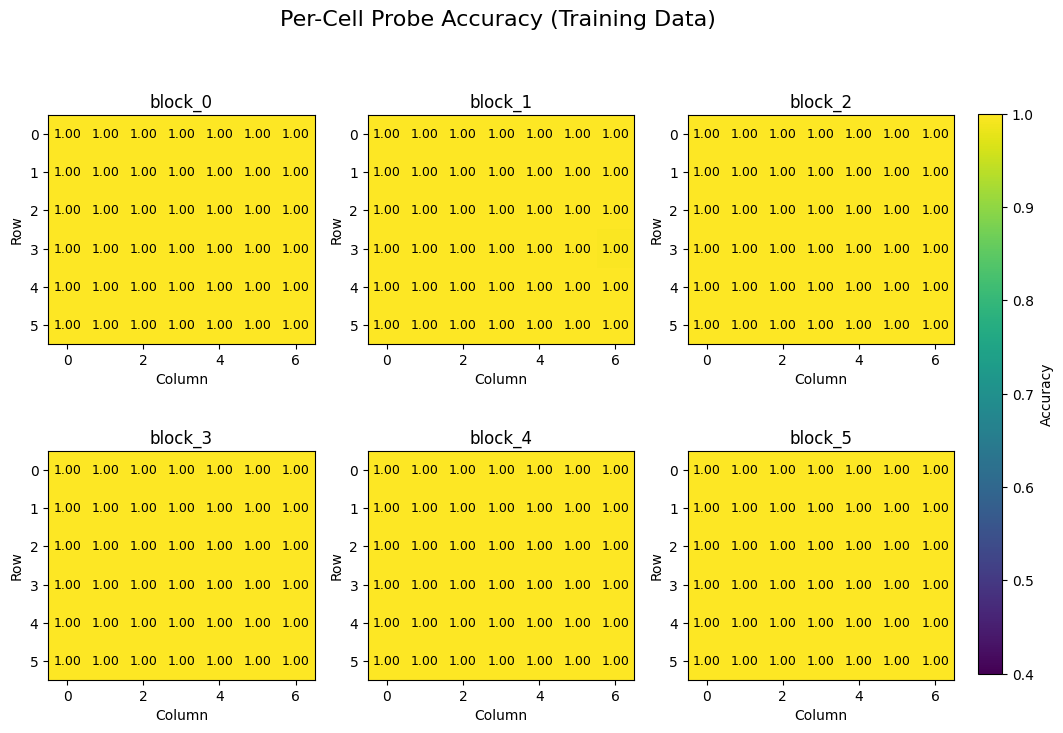

In [56]:
plot_heatmaps(train_attention_acc_cell, w=7, h=6, title=f'Per-Cell Probe Accuracy (Training Data)', xlabel='Column', ylabel='Row')

In [57]:
val_attention_acc_cell = eval_attention_probe_results(cell_attention_probe_results, val_K, val_V, val_KV_mask, val_Y_cell, val_Y_cell.shape[-1])
val_attention_acc_cell

{'block_0': tensor([0.9921, 0.9995, 0.9915, 0.9952, 0.9952, 0.9857, 0.9947, 0.9947, 0.9958,
         0.9952, 0.9921, 0.9958, 0.9942, 0.9926, 0.9915, 0.9942, 0.9942, 0.9952,
         0.9952, 0.9926, 0.9984, 0.9995, 0.9931, 0.9968, 0.9968, 0.9984, 0.9947,
         0.9900, 0.9900, 0.9974, 0.9958, 0.9921, 0.9958, 0.9931, 0.9947, 0.9921,
         0.9915, 0.9926, 0.9884, 0.9857, 0.9947, 0.9989], device='cuda:0'),
 'block_1': tensor([0.9831, 0.9905, 0.9863, 0.9894, 0.9789, 0.9746, 0.9794, 0.9900, 0.9931,
         0.9905, 0.9931, 0.9900, 0.9894, 0.9889, 0.9873, 0.9884, 0.9910, 1.0000,
         0.9958, 0.9910, 0.9937, 0.9884, 0.9889, 0.9952, 0.9921, 0.9900, 0.9847,
         0.9403, 0.9826, 0.9942, 0.9979, 0.9968, 0.9937, 0.9952, 0.9989, 0.9974,
         0.9863, 0.9878, 0.9963, 0.9847, 0.9989, 0.9926], device='cuda:0'),
 'block_2': tensor([0.9741, 0.9847, 0.9942, 0.9873, 0.9852, 0.9672, 0.9699, 0.9937, 0.9905,
         0.9942, 0.9942, 0.9910, 0.9857, 0.9852, 0.9947, 0.9958, 0.9926, 0.9968,
     

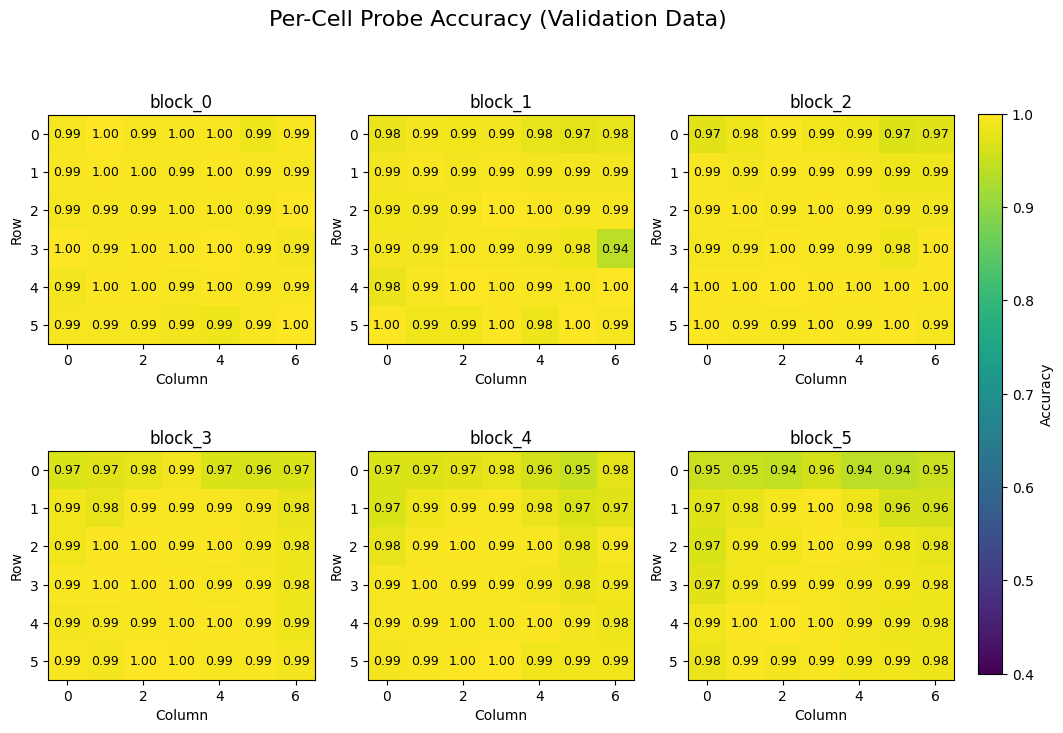

In [58]:
plot_heatmaps(val_attention_acc_cell, w=7, h=6, title=f'Per-Cell Probe Accuracy (Validation Data)', xlabel='Column', ylabel='Row')

Per column

In [59]:
train_attention_acc_col = eval_attention_probe_results(col_attention_probe_results, train_K, train_V, train_KV_mask, train_Y_col, train_Y_col.shape[-1])
train_attention_acc_col

{'block_0': tensor([0.9099, 0.9444, 0.8846, 0.9021, 0.9038, 0.8740, 0.8851],
        device='cuda:0'),
 'block_1': tensor([0.9877, 0.9744, 0.9852, 0.9856, 0.9794, 0.9726, 0.9563],
        device='cuda:0'),
 'block_2': tensor([0.9849, 0.9852, 0.9807, 0.9905, 0.9861, 0.9806, 0.9829],
        device='cuda:0'),
 'block_3': tensor([0.9890, 0.9937, 0.9872, 0.9912, 0.9928, 0.9874, 0.9857],
        device='cuda:0'),
 'block_4': tensor([0.9932, 0.9871, 0.9933, 0.9926, 0.9920, 0.9912, 0.9928],
        device='cuda:0'),
 'block_5': tensor([0.9890, 0.9898, 0.9944, 0.9902, 0.9893, 0.9900, 0.9906],
        device='cuda:0')}

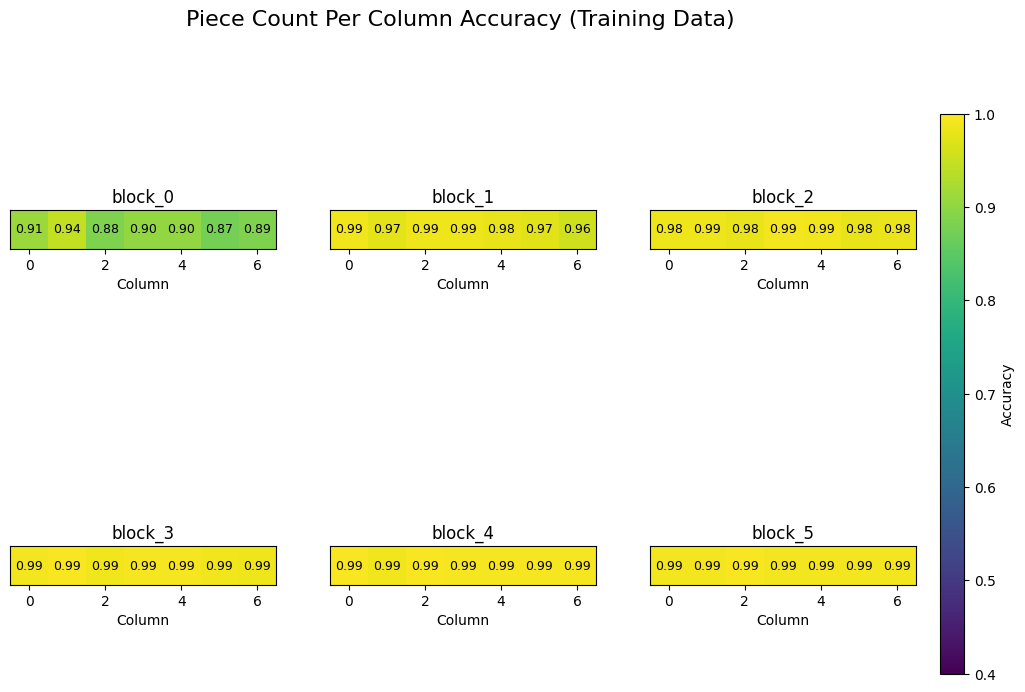

In [60]:
plot_heatmaps(train_attention_acc_col, w=7, h=1, title=f'Piece Count Per Column Accuracy (Training Data)', xlabel='Column', ylabel='', disable_yticks=True)

In [61]:
val_attention_acc_col = eval_attention_probe_results(col_attention_probe_results, val_K, val_V, val_KV_mask, val_Y_col, val_Y_col.shape[-1])
val_attention_acc_col

{'block_0': tensor([0.8742, 0.9054, 0.8235, 0.8626, 0.8552, 0.8372, 0.8499],
        device='cuda:0'),
 'block_1': tensor([0.9434, 0.9112, 0.9456, 0.9456, 0.9318, 0.9123, 0.8837],
        device='cuda:0'),
 'block_2': tensor([0.9360, 0.9403, 0.9186, 0.9593, 0.9339, 0.9043, 0.9234],
        device='cuda:0'),
 'block_3': tensor([0.9508, 0.9619, 0.9493, 0.9572, 0.9514, 0.9334, 0.9329],
        device='cuda:0'),
 'block_4': tensor([0.9498, 0.9297, 0.9434, 0.9445, 0.9339, 0.9308, 0.9355],
        device='cuda:0'),
 'block_5': tensor([0.9286, 0.9223, 0.9329, 0.9228, 0.9170, 0.9070, 0.9276],
        device='cuda:0')}

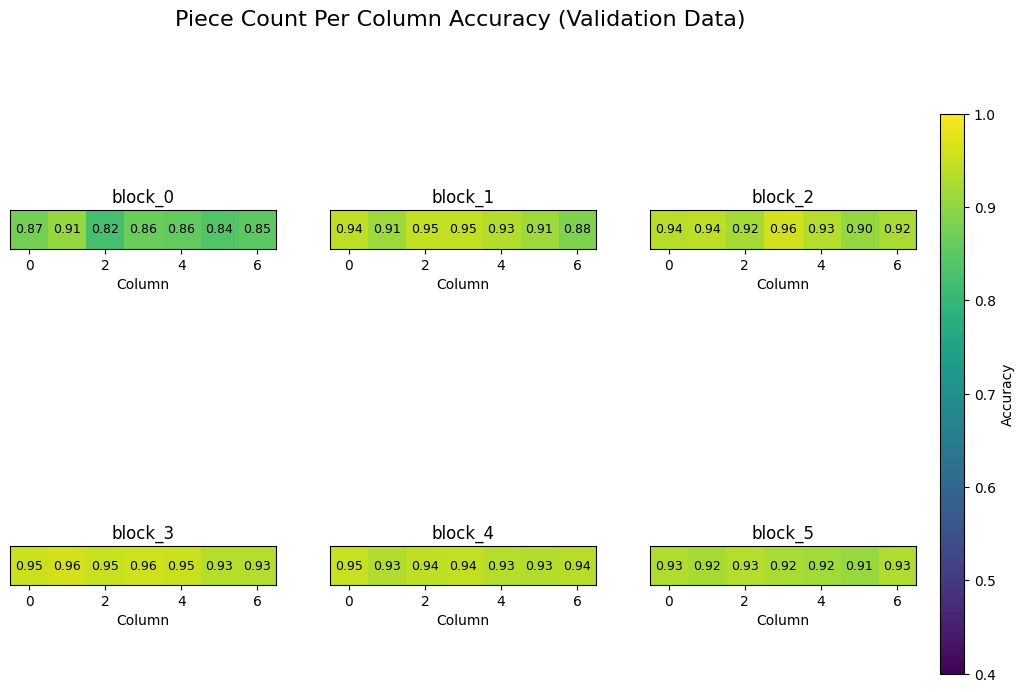

In [62]:
plot_heatmaps(val_attention_acc_col, w=7, h=1, title=f'Piece Count Per Column Accuracy (Validation Data)', xlabel='Column', ylabel='', disable_yticks=True)

Per row

In [63]:
train_attention_acc_row = eval_attention_probe_results(row_attention_probe_results, train_K, train_V, train_KV_mask, train_Y_row, train_Y_row.shape[-1])
train_attention_acc_row

{'block_0': tensor([0.8218, 0.8123, 0.7849, 0.8221, 0.7630, 0.7674], device='cuda:0'),
 'block_1': tensor([0.9447, 0.8896, 0.8354, 0.8143, 0.8503, 0.8466], device='cuda:0'),
 'block_2': tensor([0.9237, 0.9030, 0.9114, 0.8487, 0.8388, 0.8799], device='cuda:0'),
 'block_3': tensor([0.9560, 0.9384, 0.9415, 0.9252, 0.9274, 0.9330], device='cuda:0'),
 'block_4': tensor([0.9431, 0.9289, 0.9073, 0.9115, 0.8995, 0.9574], device='cuda:0'),
 'block_5': tensor([0.9078, 0.9212, 0.8926, 0.8864, 0.8792, 0.9429], device='cuda:0')}

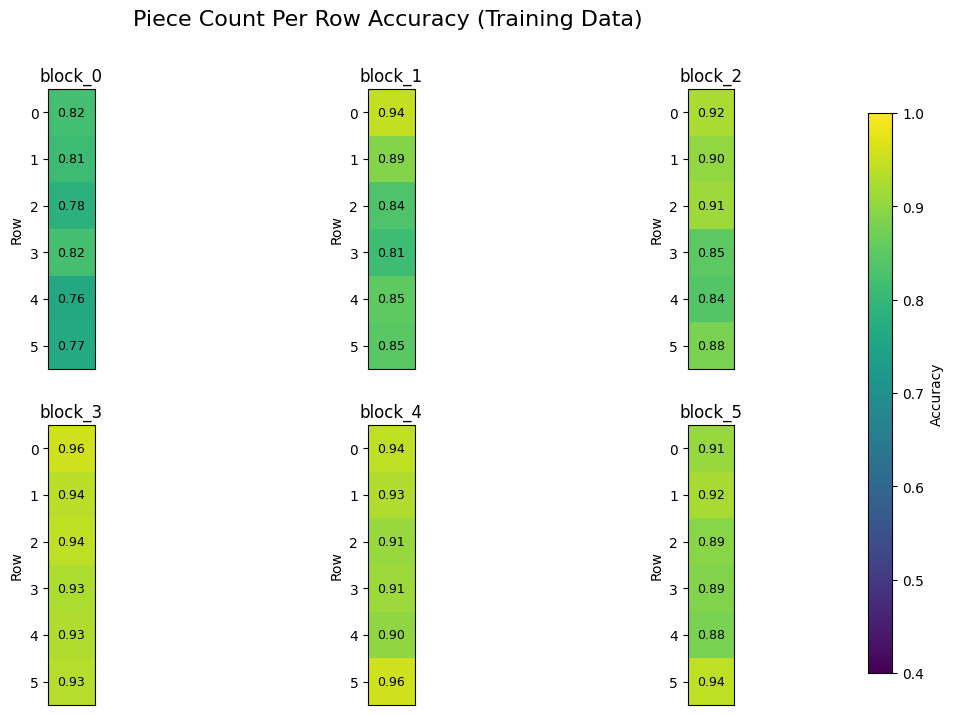

In [64]:
plot_heatmaps(train_attention_acc_row, w=1, h=6, title=f'Piece Count Per Row Accuracy (Training Data)', xlabel='', ylabel='Row', disable_xticks=True)

In [65]:
val_attention_acc_row = eval_attention_probe_results(row_attention_probe_results, val_K, val_V, val_KV_mask, val_Y_row, val_Y_row.shape[-1])
val_attention_acc_row

{'block_0': tensor([0.7717, 0.7659, 0.7119, 0.7421, 0.6749, 0.6903], device='cuda:0'),
 'block_1': tensor([0.8795, 0.7849, 0.6829, 0.6279, 0.7119, 0.7553], device='cuda:0'),
 'block_2': tensor([0.8277, 0.7923, 0.8039, 0.7119, 0.6977, 0.7696], device='cuda:0'),
 'block_3': tensor([0.8303, 0.8013, 0.8150, 0.7537, 0.7526, 0.8055], device='cuda:0'),
 'block_4': tensor([0.8076, 0.7637, 0.7061, 0.7114, 0.7310, 0.8673], device='cuda:0'),
 'block_5': tensor([0.7859, 0.7738, 0.7236, 0.7024, 0.7463, 0.8584], device='cuda:0')}

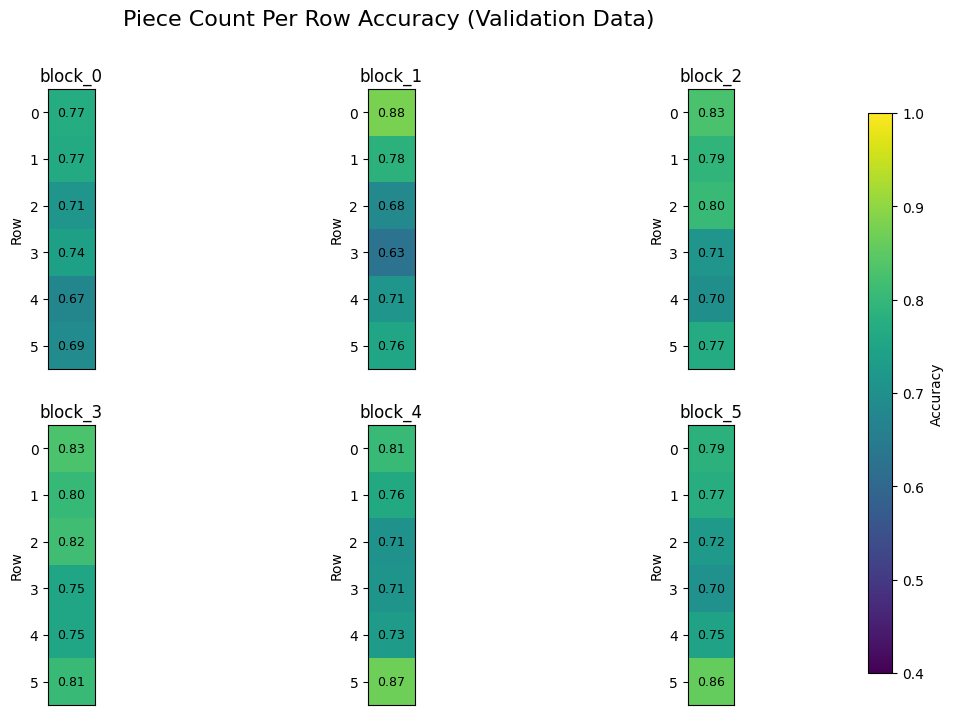

In [66]:
plot_heatmaps(val_attention_acc_row, w=1, h=6, title=f'Piece Count Per Row Accuracy (Validation Data)', xlabel='', ylabel='Row', disable_xticks=True)

### Visualize learned Q vectors

In [67]:
from sklearn.decomposition import PCA

In [89]:
def plot_q_pca_layers(
    probes_dict,
    board_shape=(6,7),
    title="PCA of q vectors per layer",
    probe_name="Cell probe",
    max_cols=3,
    color_by="col"
):
    keys = sorted(probes_dict.keys())
    n = len(keys)

    cols = min(n, max_cols)
    rows = math.ceil(n / cols)

    fig, axes = plt.subplots(
        rows,
        cols,
        figsize=(4 * cols, 4 * rows),
        squeeze=False
    )

    fig.suptitle(f"{title} ({probe_name})", fontsize=16)

    H, W = board_shape

    for idx, key in enumerate(keys):
        r = idx // cols
        c = idx % cols
        ax = axes[r][c]

        probe = probes_dict[key]
        q = probe.q.detach().cpu().numpy()

        q2 = PCA(n_components=2).fit_transform(q)

        if color_by == "row":
            colors = [i // W for i in range(H*W)]
        elif color_by == "col":
            colors = [i % W for i in range(H*W)]
        else:
            colors = None

        ax.scatter(q2[:,0], q2[:,1], c=colors)

        for i,(x,y) in enumerate(q2):
            rr = i // W
            cc = i % W
            txt = f"{cc}" if H == 1 else f"{rr}" if W == 1 else f"{rr},{cc}"
            ax.text(x, y, txt, fontsize=7)

        ax.set_title(key)
        ax.set_xticks([])
        ax.set_yticks([])

    for i in range(n, rows * cols):
        fig.delaxes(axes[i // cols][i % cols])

    plt.tight_layout()
    plt.show()

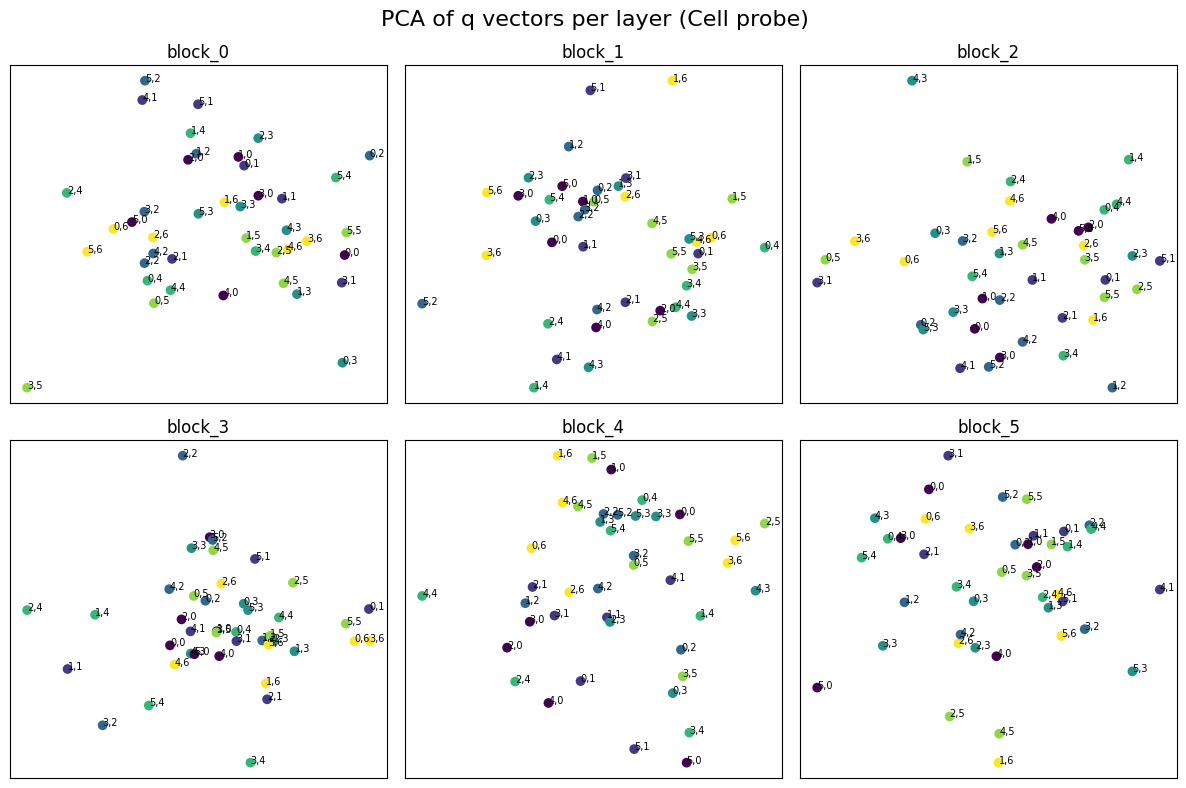

In [90]:
plot_q_pca_layers(cell_attention_probe_results)

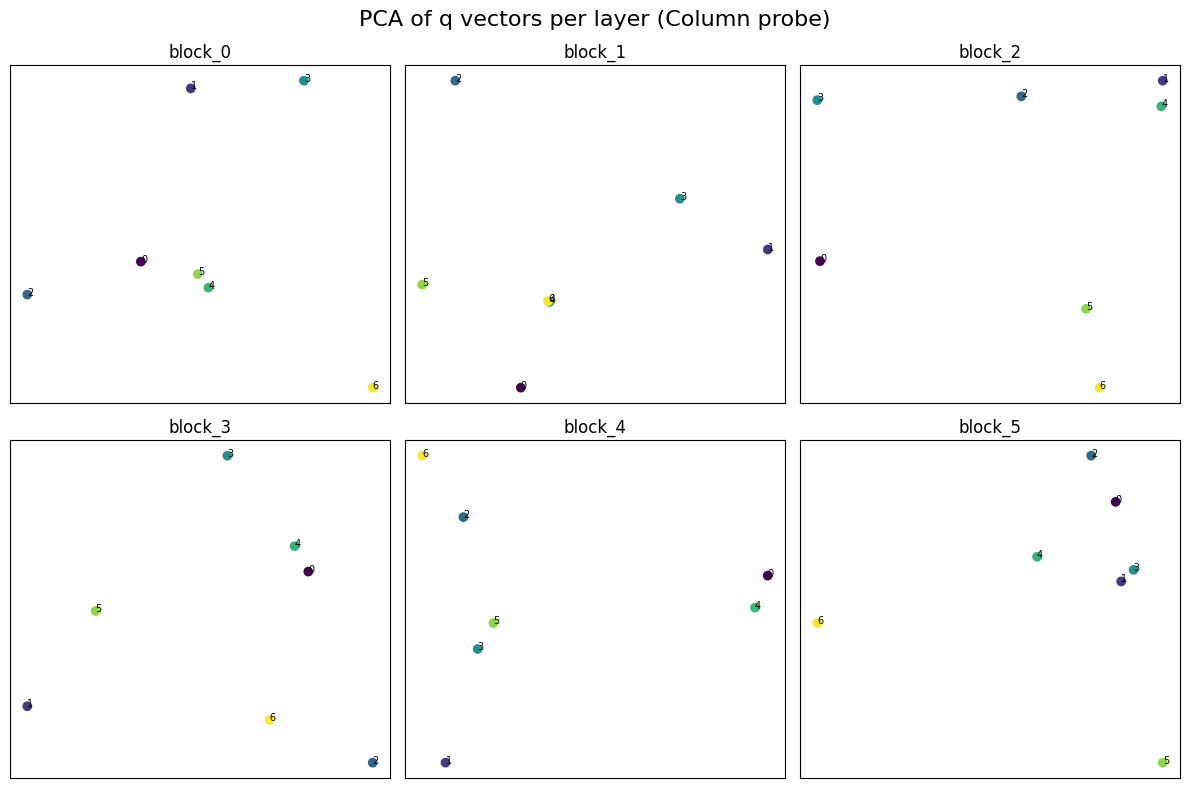

In [91]:
plot_q_pca_layers(col_attention_probe_results, board_shape=(1,7), probe_name="Column probe")

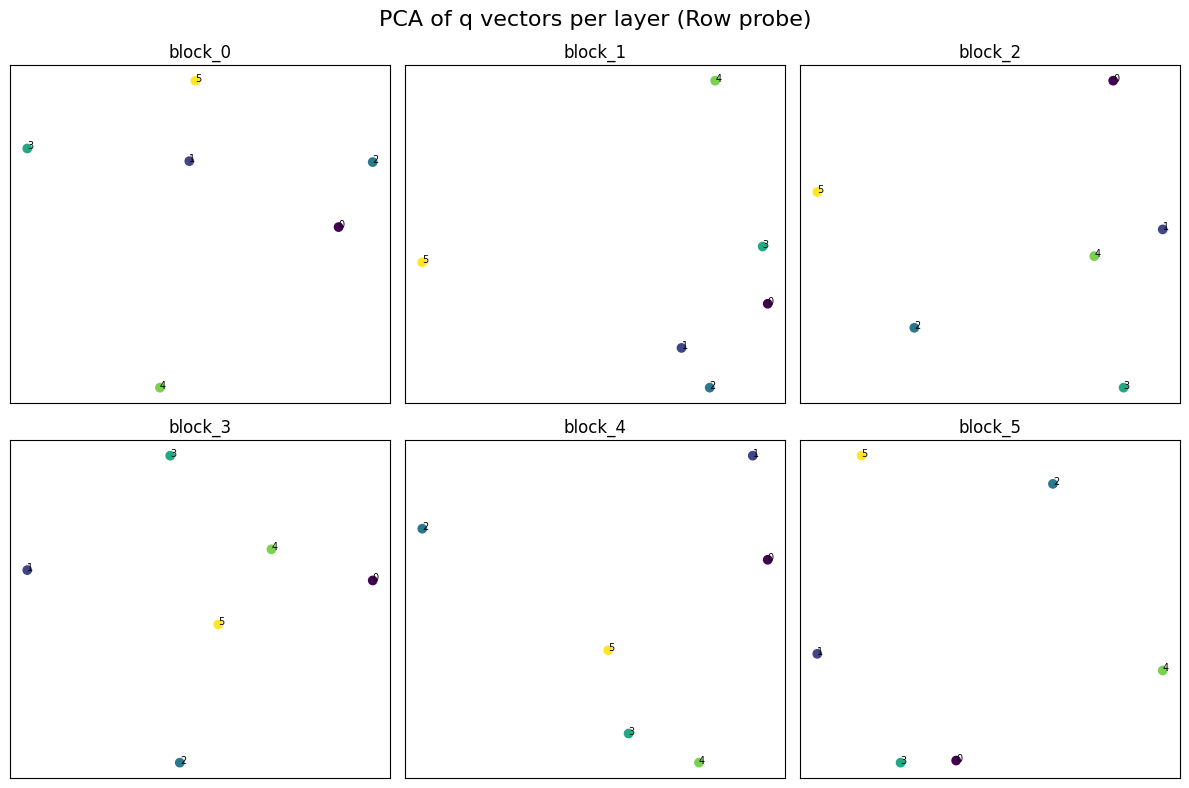

In [92]:
plot_q_pca_layers(row_attention_probe_results, board_shape=(6,1), probe_name="Row probe", color_by="row")